# Esercitazione 4

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k

suff=["epot","ekin","temp","etot","pres"]
tit=[
    "Energia Potenziale",
    "Energia Cinetica",
    "Temperatura",
    "Energia Totale",
    "Pressione"
]
colors=[
    "#731733",
    "#A16D82",
    "#BE6266",
    "#E87673",
    "#8F3C3E"
]
yaxes=[
    r"$\langle U/N \rangle\, [J]$",
    r"$\langle K/N \rangle\,[J]$",
    r"$\langle T \rangle\,[K]$",
    r"$\langle E/N \rangle\,[J]$",
    r"$\langle P/N \rangle\,[Pa]$"
]

def graph(data,title,X,term):
    fig,axx = plt.subplots(3,2,figsize=(12,10))
    axx=np.reshape(axx,6)
    x,y=(0,0)
    i=0
    appo=0
    
    for ax in axx[0:-1]:
        if (i==2):
            appo=X["theta"]
        elif (i<4):
            appo=X["theta"]*k
        else:
            appo=X["theta"]*k/(X["sigma"]**3)

        y=i%2
        x=int(i/2)
        ax.errorbar(data[i][:,0],data[i][:,2]*appo, yerr=data[i][:,3]*appo,color=colors[i],label="Media Complessiva")
        if (term):
            ax.plot(data[i][:,0],data[i][:,1]*appo,color="orange",label="Media Blocchi")
        ax.plot(data[i][:,0],np.ones(int(data[i][-1,0]))*data[i][-1,2]*appo,color="red")
        ax.grid()
        ax.legend()
        ax.set(xlabel="Numero blocchi",ylabel=yaxes[i])
        ax.set_title(tit[i])
        i+=1
        
    axx[-1].axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

## 1 Dinamica Molecolare

La __dinamica molecolare__ descrive le componenti macroscopici di un corpo tramite la stima di medie dei comportamenti microscopici delle parti che lo compongono e le loro equazioni del moto.  Per questo utilizziamo la *fisica statistica*.

Questi studi hanno bisogno di avvenire ad energia costante, perciò utilizziamo un algorimo simile all'__algoritmo di Varlet__.  Qust'ultimo prende in considerazione spostamenti in infinitesimi di tempo $\delta t$ per fare uno sviluppo di Taylor.
$$
\vec{r}(t\pm\delta t)=\vec{r}(t)\pm\delta t \, \vec{v}+\frac{1}{2}{\delta t}^2\,\vec{a}+ o({\delta t}^3)
$$
Per togliere le dipendenze dalla velocità sommiamo la serie valutata in $t-\delta t$ e valutata in $t-\delta t$, così da ottenere:
$$
\vec{r}(t+\delta t)\approx 2\vec{r}(t)-\vec{r}(t-\delta t)+\vec{a} {\delta t}^2
$$
Sapendo lo spostamento e l'intervallo di tempo in cui avviene troviamo facilmente la velocità:
$$
\vec{v}(r)=\frac{\vec{r}(t+\delta t)-\vec{r}(t-\delta t)}{2\, \delta t}
$$

<font color=red>N.B.</font> questo algoritmo ha due importanti caratteristiche:

1. __Non self-starting__: non basta sapere le varie $\vec{r}(0)$ e $\vec{v}(0)$ per inizializzare il sistema, abbiamo bisogno di altre informazioni.
2. __Reversibile temporalmente__: $\vec{r}(t+\delta t)$ e $\vec{r}(t-\delta)$ hanno ruoli simmetrici e possono essere invertiti.

Per simulare questo sistema prendiamo in considerazione una porzione (*cella*) del corpo sotto studio e le applichiamo le condizioni periodiche al contorno (*PBC*), cioè per ogni particella che esce da un lato della cella ne entra una da un altro lato, deciso in base alle simmetrie del problema.

Teniamo conto di particelle in una cella cubica che sentono interazione delle altre particelle descritto dal potenziale di *Leonard-Jonson*.

Per siulare il sistema utilizziamo un sistema di unità di misura naturale per potere simulare un'infinità di casi simultaneamente e semplificare i conti.  In questo modo possiamo simulare generalmente qualsiasi sistema per poi convertire ed avere i risultati specifiche sapendo le caratteristiche del campione.

Come configurazione iniziale utiliziamo un reticolo cristallino per evitare sovrapposizioni di particelle che altererebbero le misure e non sarebbero possibili fisicamente.  Questo vuol dire che facciamo partire il sistema da una configurazione improbabile per temperature abbastanza lontane da $0\,K$, perciò prima di analizzare i risultati della simulazione dobbiamo farla termalizzare quindi fare dei cicli per far stabilizzare i valori restituiti. 

### 1.1 Pressione

Il codice fornitoci calcola già:
- Energia totale per particella $\frac{E}{N}$.
- Energia potenziale per particella $\frac{U}{N}$.
- Energia cinetica per particella $\frac{K}{N}$

Implementiamo il calcolo della *pressione* $P$.  Sapendo il *teorema del viriale*, il calcolo della pressione è:
$$
P=\rho\,k_B\,T+\frac{1}{3\,V}\left\langle \sum_{i=1}^{N-1} \sum_{j(>i)}^{N} 48\epsilon\left[ \left( \frac{\sigma}{\left|\vec{r_i}-\vec{r_j}\right|} \right)^{12}- \frac{1}{2} \left( \frac{\sigma}{\left| \vec{r_i}-\vec{r_j} \right|} \right)^6 \right] \right\rangle
$$

### 1.2 Analisi delle Osservabili Macroscopiche

Prendiamo come campione l'*argon*:
- $\sigma = 0.34 \, nm$
- $\frac{\epsilon}{k_B}= 120 \, K$
- $m= 39.948 \, amu$

Utilizziamo il nostro codice per studiare ter diverse configurazioni:
1. __Fase solida__: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
2. __Fase liquida__: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
3. __Fase gassosa__: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

In [2]:
Argon={
    "sigma": 0.34 ,
    "theta": 120 ,
    "m": 39.948
}

#### 1.2.1 Termalizzazione

Come accennato in precedenza la configurazione di partenza non è una configurazione vicino all'equilibrio, infatti dobbiamo far andare la simulazione finchè le oscillazioni diventano trascurabili e le nostre condizioni diventano pressochè stabili.

Visto queste variazioni la temperature di input non corrisponde a quella finale: per risolvere questo problema si inizializza il problema con una temperatura più alta.

__Fase Solida__

Iniziamo a vedere l'andamento per $1000$ con un singolo step.  Confrontiamo la media dei singoli blocchi con la media complessiva ed evidenziamo il valore di quest'ultima al termine dell'evoluzione.

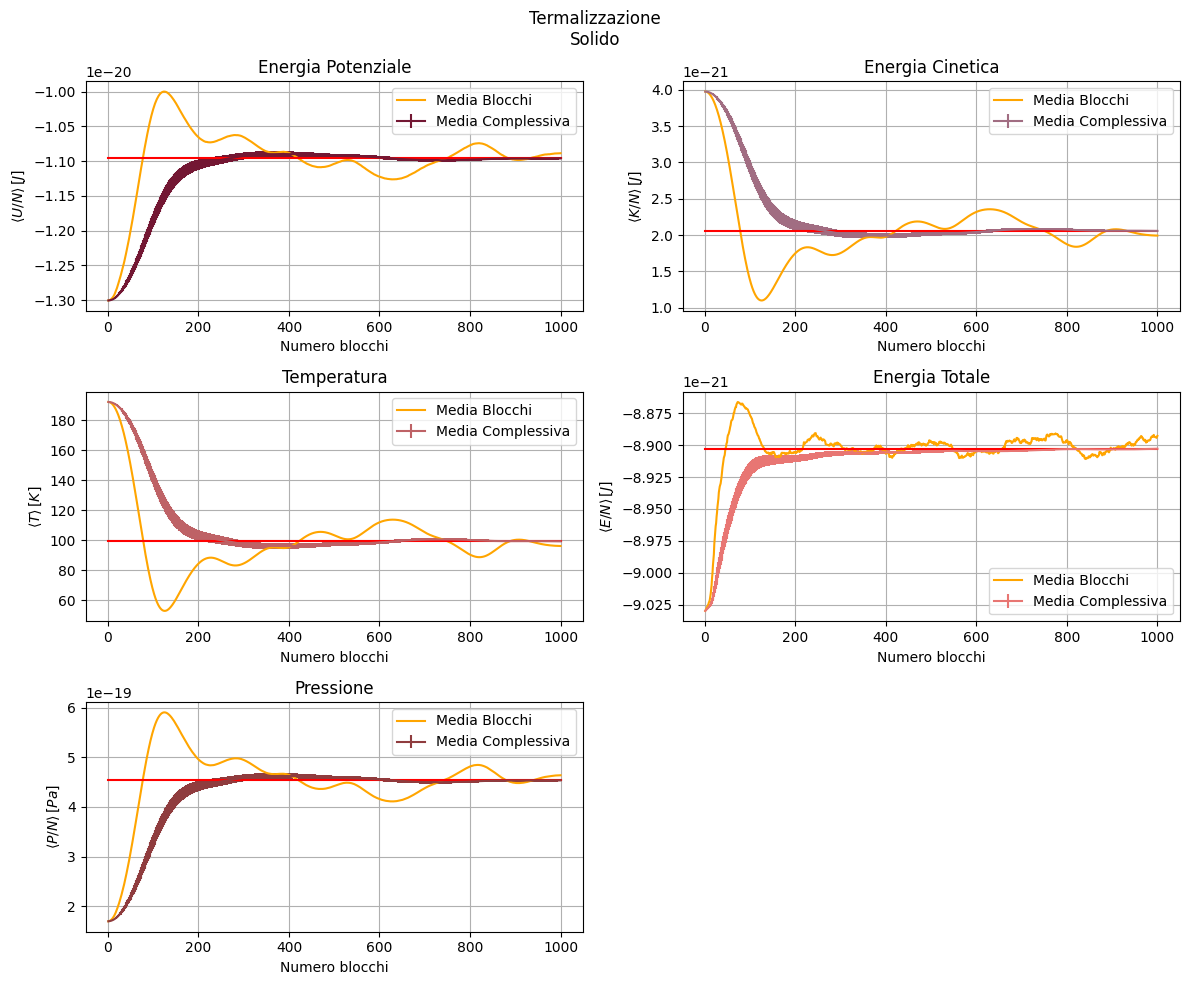

In [30]:
data=[]
for s in suff:
    data.append(np.loadtxt("Termalization/Solid/output_"+s+".dat"))

graph(data,f"Termalizzazione\nSolido",Argon,True)

Il sistema si *termalizza*, intorno a $200$ step: vediamo che le medie dei blocchi di tutte le osservabili finiscono di variare bruscamente ed iniziano ad oscillare, inoltre la media complessiva si stabilizza.

__Fase Liquida__

Ripetiamo lo stesso procedimento per la fase liquida.

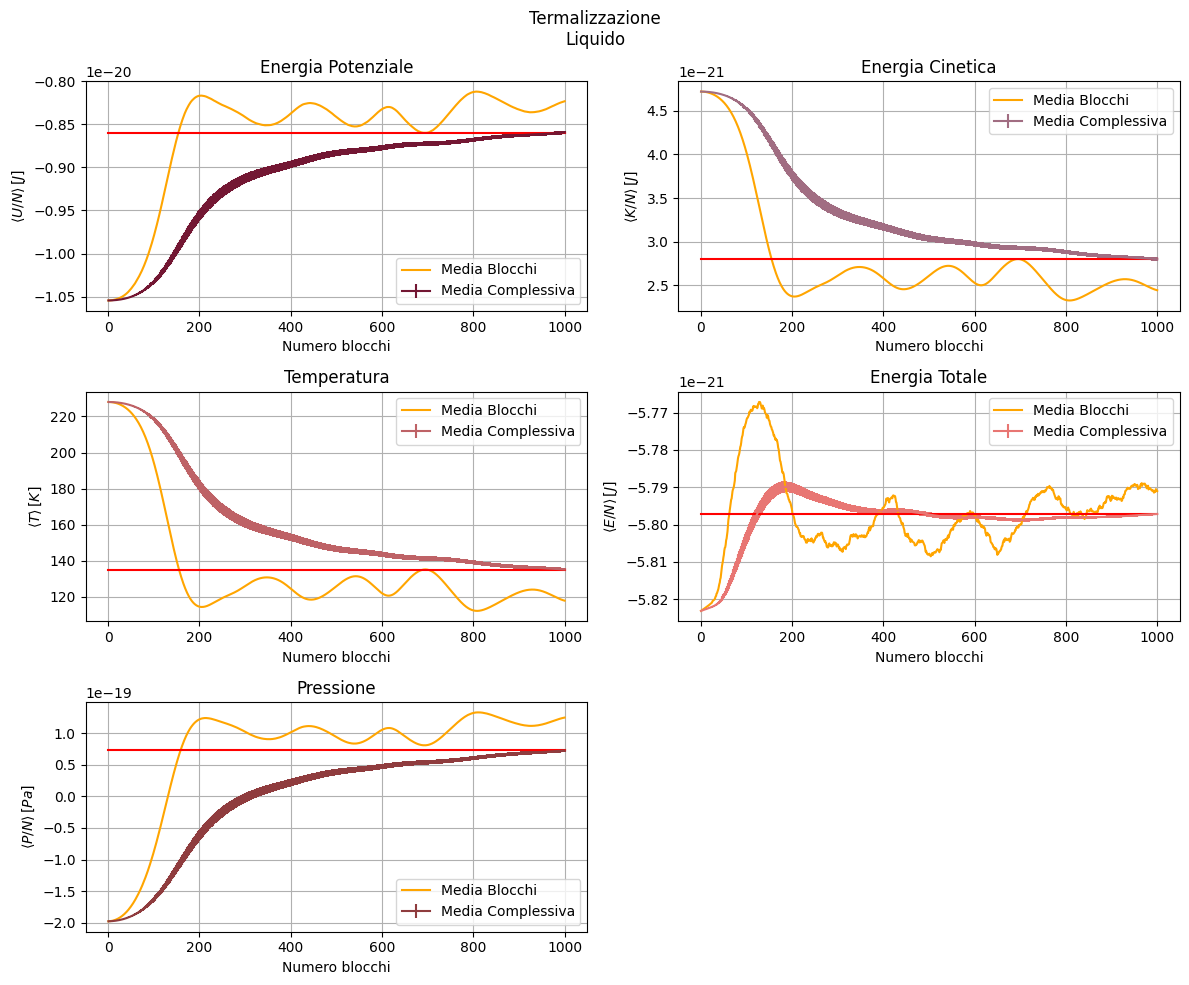

In [31]:
data=[]
for s in suff:
    data.append(np.loadtxt("Termalization/Liquid/output_"+s+".dat"))

graph(data,f"Termalizzazione\nLiquido",Argon,True)

Questa volta la media le medie complessive non si stabilizzano a causa della forte influenza dei primi valori, però osserviamo che poco dopo $200$ i valori dei singoli blocchi inizaino ad oscillare.

__Fase Gassosa__

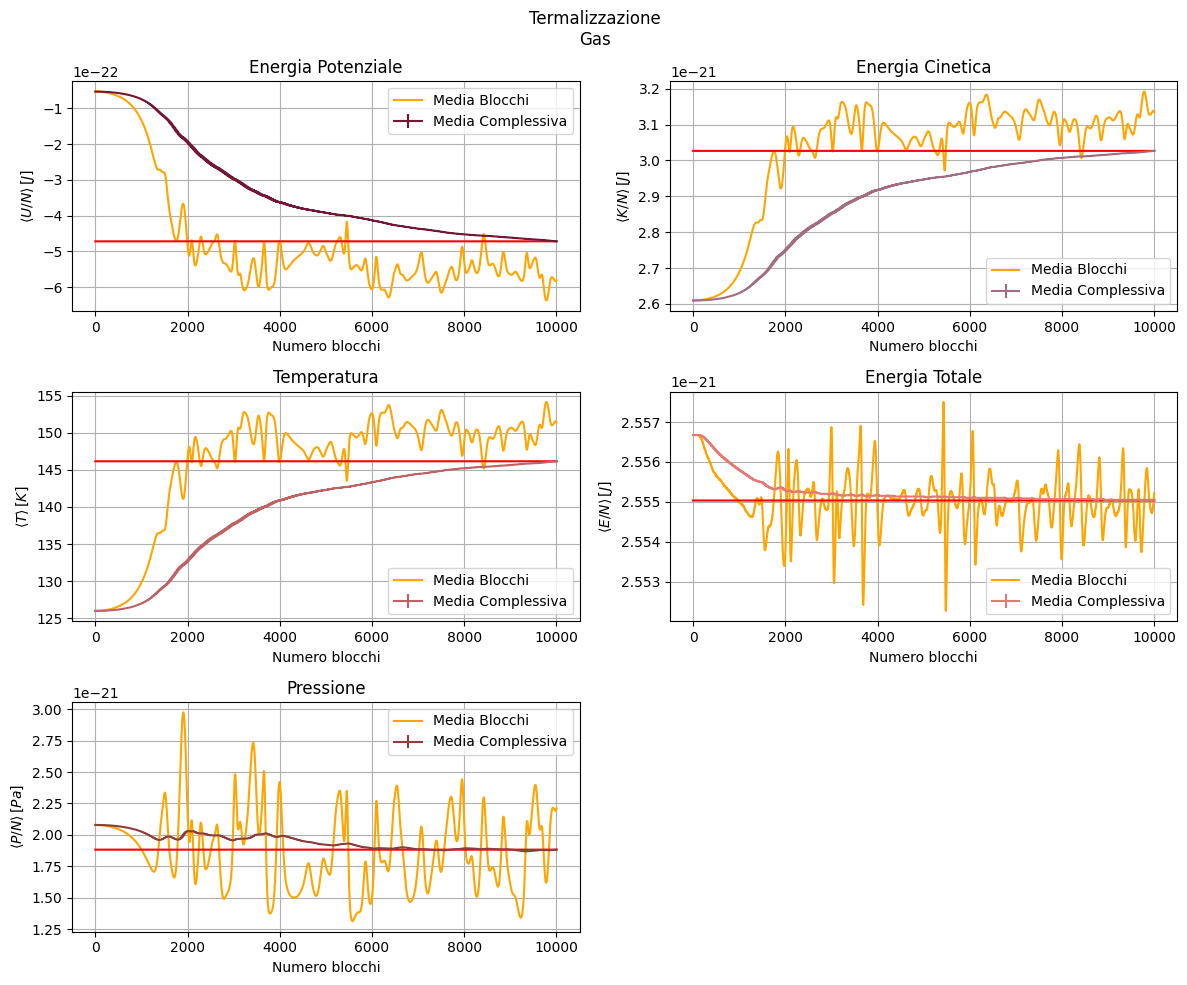

In [43]:
data=[]
for s in suff:
    data.append(np.loadtxt("Termalization/Gas/output_"+s+".dat"))

graph(data,f"Termalizzazione\nGas",Argon,True)

Possiamo vedere che nel caso del *gas* la termalizzazione è più lunga e le fluttuazioni sono sempre più importanti rispetto a le altre casistiche.  Nonostante ciò possiamo vedere che a $2000$ step le grandezze iniziano ad oscillare, perciò possiamo dire che il sistema è *termalizzato*. 

#### 1.2.2 Simulazione del Sistema

Una volta stabilita la termalizzazione del sistema possimo procedere con lo studio del sistema.

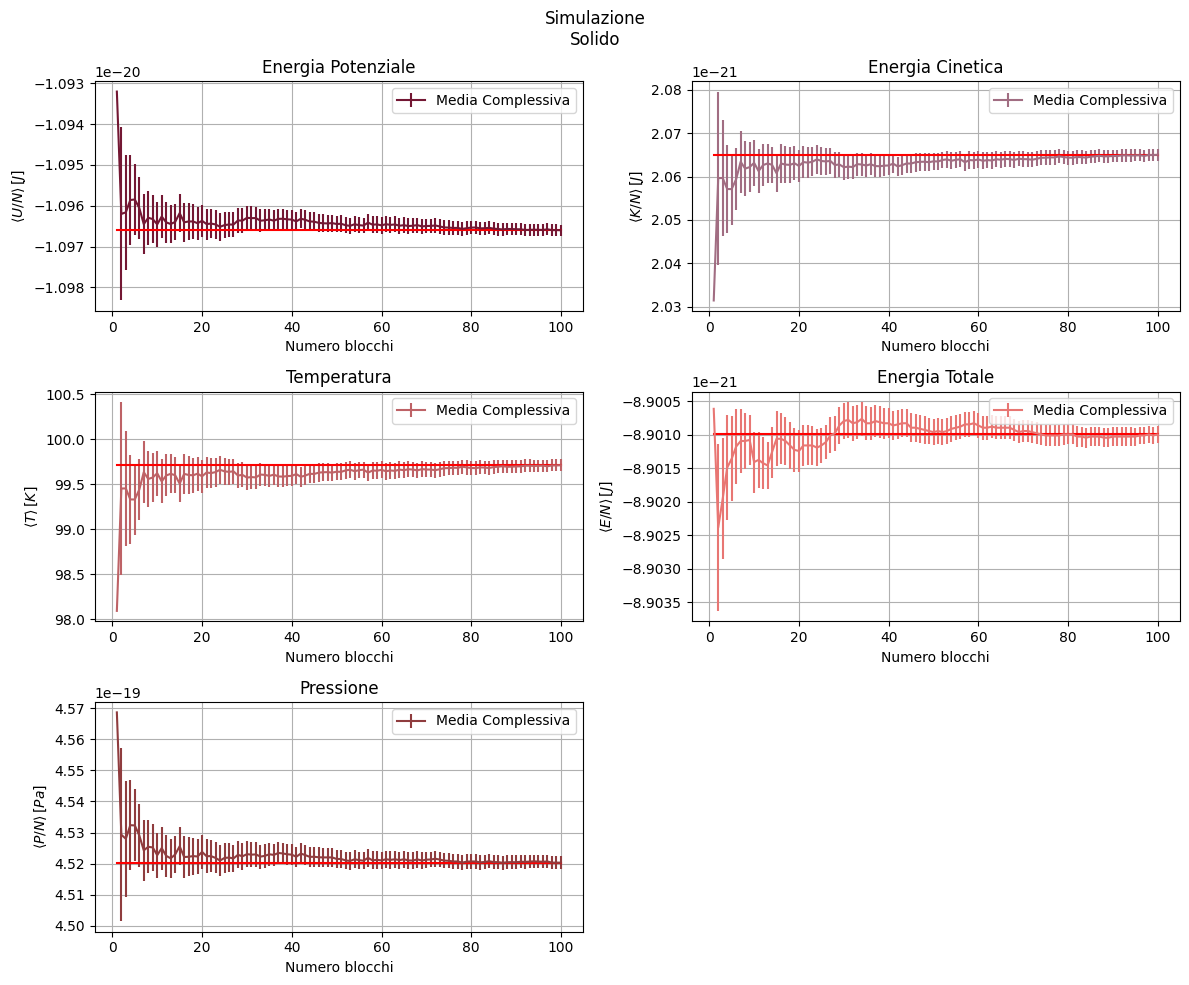

In [49]:
data=[]
for s in suff:
    data.append(np.loadtxt("System/Solid/output_"+s+".dat"))

graph(data,f"Simulazione\nSolido",Argon,False)

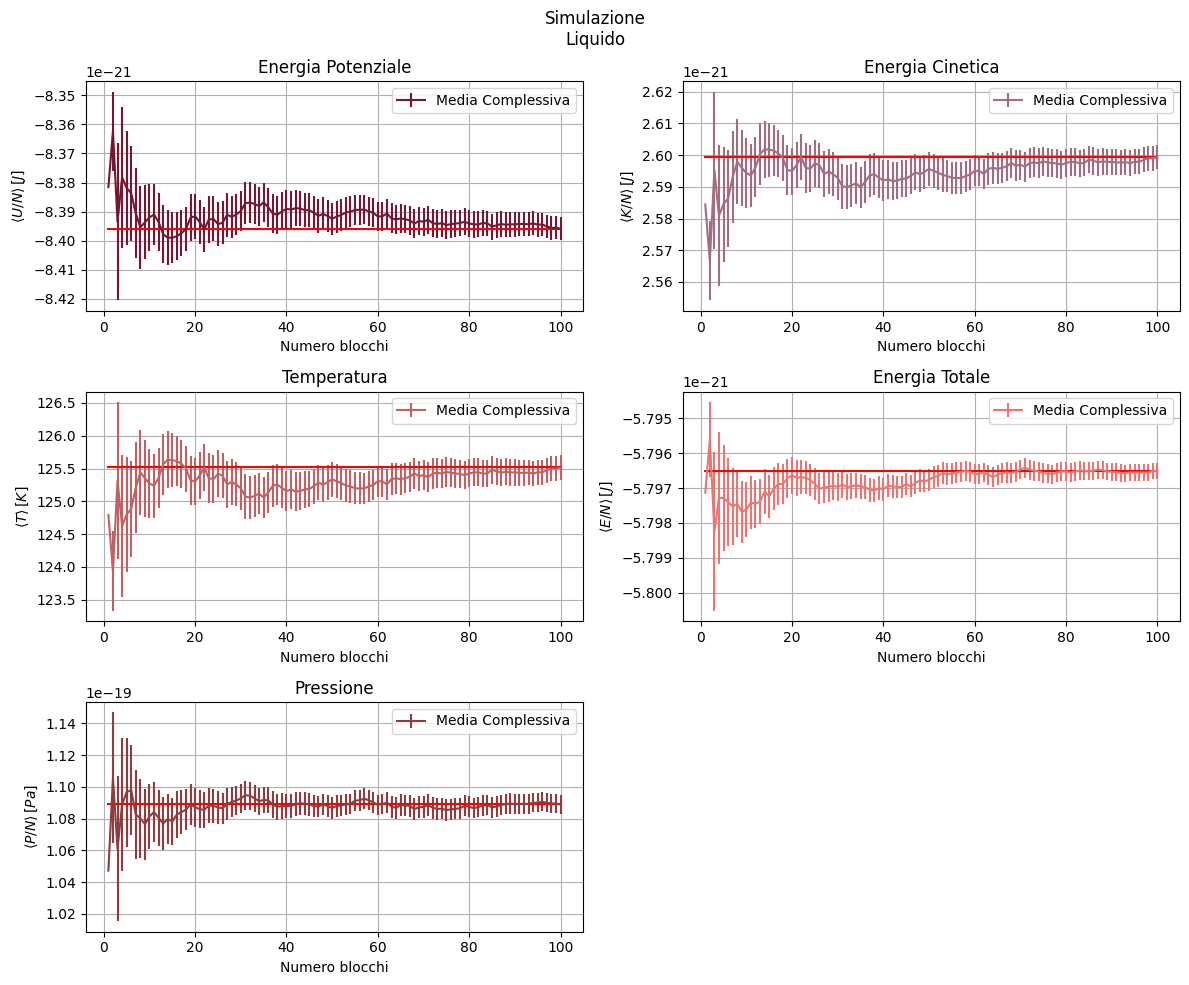

In [51]:
data=[]
for s in suff:
    data.append(np.loadtxt("System/Liquid/output_"+s+".dat"))

graph(data,f"Simulazione\nLiquido",Argon,False)

# Appendice

Questo codice serve a vedere l'output del codice.

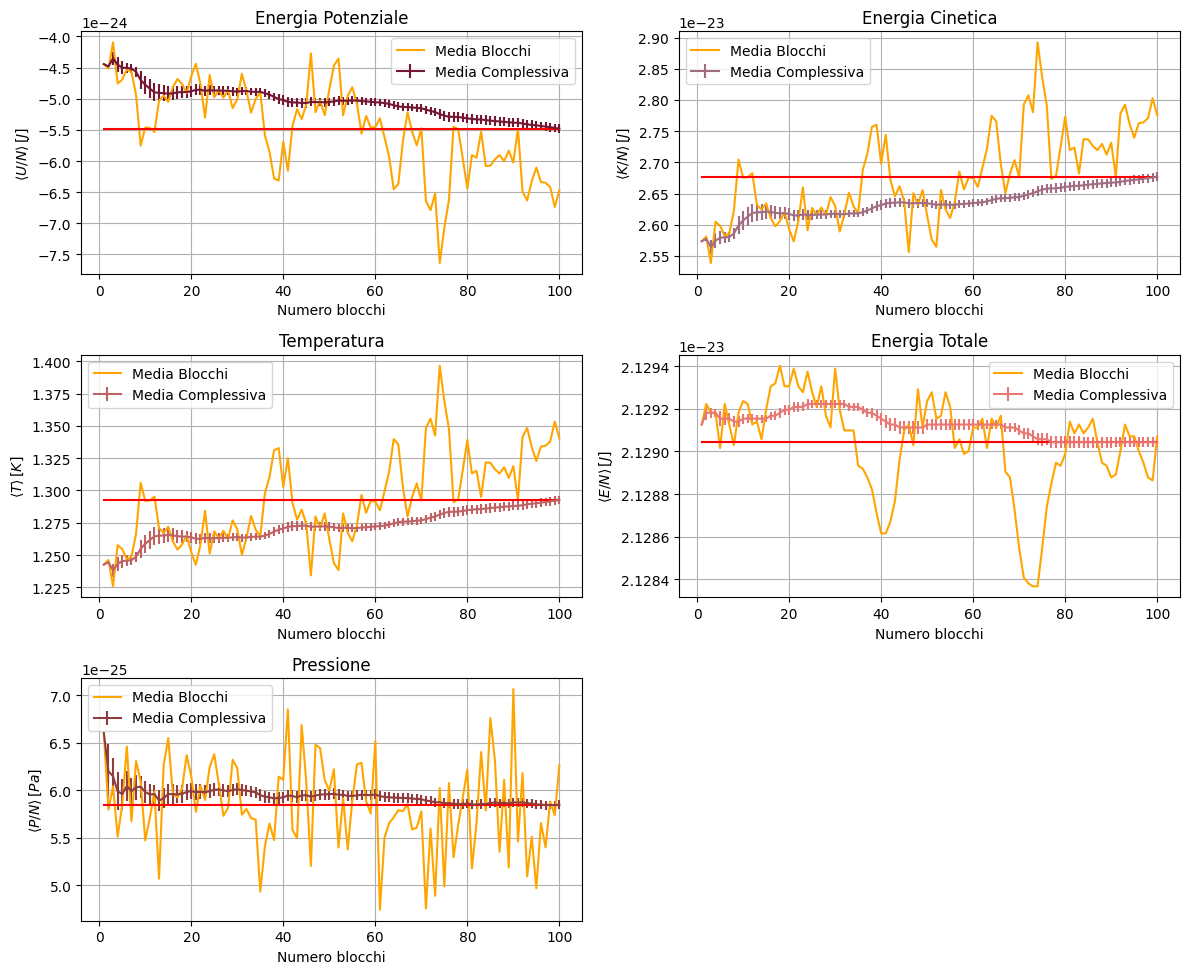

In [52]:
data=[]

for s in suff:
    data.append(np.loadtxt("../MD_MC/MDNVE_MCNVT/output_"+s+".dat"))

unit={
    "sigma": 1,
    "theta": 1
}

graph(data,"",unit,True)